In [11]:
import numpy as np
import pandas as pd 
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

import random

from plotly import graph_objects as go
from collections import Counter
from tqdm import tqdm
from scipy.stats import sem


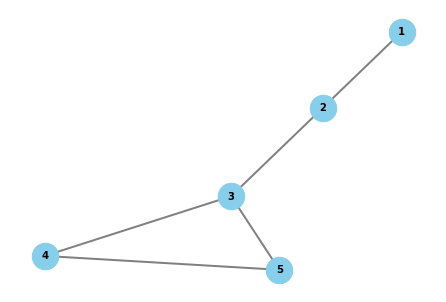

In [12]:
G = nx.Graph()


nodes = [1, 2, 3, 4, 5]
G.add_nodes_from(nodes)


edges = [(1, 2), (2, 3), (3, 4), (3, 5), (4, 5)]
G.add_edges_from(edges)


pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_color='black', font_weight='bold', width=2, edge_color='gray' )


plt.show()


# Question 1A

In [13]:
degrees = Counter([x for tup in edges for x in tup])


fig = go.Figure()
fig.add_trace(go.Bar(x=list(degrees.keys()), y=list(degrees.values())))


fig.update_layout(
    title='Histogram of Degrees',
    xaxis=dict(title='Node'),
    yaxis=dict(title='Edges')
)


fig.show()

# Question 1B

In [14]:
adjacency_matrix = nx.adjacency_matrix(G)


dense_adjacency_matrix = adjacency_matrix.toarray()


df = pd.DataFrame(data=dense_adjacency_matrix, columns=nodes, index=nodes)


plt.figure(figsize=(8, 6))
sns.heatmap(df, cmap='viridis', cbar=False, yticklabels=True, annot=True)
plt.title('Adjacency Matrix:')
plt.show()

AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

# Question 1C

In [15]:
for x, y in nx.betweenness_centrality(G).items():
    print(x,":",y)

1 : 0.0
2 : 0.5
3 : 0.6666666666666666
4 : 0.0
5 : 0.0


# Epidemics, question 1
## B

In [16]:
def infected(i, r):
    """
    Set a node to infected based on probability.
    """
    if np.random.rand() < (1 - (1 - i) ** r):
        return 'I'
    else:
        return 'S'

def reproduction_number(I_plus_one, I):
    """
    Derivethe expression for the expected number of new infections in the
    first time step per infected vertex in both cases.
    """
    return round((I_plus_one - I) / I, DECIMAL_ROUND)

def simulate_infection(graph, probability_of_infection):
    """
    The simulate_infection function iterates through a graph, updating the status of susceptible nodes ('S')
    based on the probability of infection and the count of infected neighbors.
    """
    for node, data in graph.nodes(data=True):
        if data['status'] == 'S':
            neighbors = list(nx.neighbors(graph, node))
            amount_of_infected_neighbors = sum(1 for neighbor in neighbors if graph.nodes[neighbor]['status'] == 'I')
            graph.nodes[node]['status'] = infected(probability_of_infection, amount_of_infected_neighbors)
            
def random_infected_init(N, graph, infected_init):
    """
    Set a random portion of the population to infected,
    based on the infected_init variable.
    """    
    total_infected = 0
    
    for node in graph.nodes():
        if (node / N) <= infected_init:
            graph.nodes[node]['status'] = 'I'
            total_infected += 1
            
    total_susceptible = N - total_infected    
    return total_infected, total_susceptible

In [17]:
def run_simulation(case, T, infected_init):
    """
    The run_simulation function models infection spread in an Erdos-Renyi random graph
    with an initial infected fraction.
    It iteratively simulates infection dynamics over T time steps,
    tracking counts and fractions of infected and susceptible nodes, along with the reproduction number.
    """
    N = case['N']
    i = case['i']
    average_k = case['average_k']

    # Create graph
    probability_of_infection = i
    erdos_renyi = nx.fast_gnp_random_graph(n=N, p=average_k/N)
    nx.set_node_attributes(erdos_renyi, 'S', "status")
    total_infected, total_susceptible = random_infected_init(N, erdos_renyi, infected_init)
    
    # Initial starting values
    infected_counts = [total_infected]
    susceptible_counts = [total_susceptible]
    infected_fractions = [round(total_infected / N, DECIMAL_ROUND)]
    susceptible_fractions = [round(total_susceptible / N, DECIMAL_ROUND)]
    R0 = []

    for t in range(T):
        simulate_infection(erdos_renyi, probability_of_infection)
        
        total_infected = sum(1 for _, data in erdos_renyi.nodes(data=True) if data['status'] == 'I')
        infected_counts.append(total_infected)
        infected_fractions.append(round(total_infected / N, DECIMAL_ROUND))
        R0.append(reproduction_number(infected_counts[t], infected_counts[t-1]))
        
        total_susceptible = sum(1 for _, data in erdos_renyi.nodes(data=True) if data['status'] == 'S')
        susceptible_counts.append(total_susceptible)
        susceptible_fractions.append(round(total_susceptible / N, DECIMAL_ROUND))
        
    case['infected_counts'] = infected_counts
    case['susceptible_counts'] = susceptible_counts
    case['infected_fractions'] = infected_fractions
    case['susceptible_fractions'] = susceptible_fractions
    case['R0'] = R0
    # Change the first value to positive
    case['R0'][0] = case['R0'][0] * -1    
        
    return case

def run_evolution(cases, num_simulations, T, infected_init):
    """
    Run the evolution for plotting by calculating mean and confidence intervals.
    """     
    
    
    for index, case in enumerate(cases):
        for _ in tqdm(range(num_simulations)):
            results = []
            run_simulation(case=cases[index], T=T, infected_init=infected_init)
            results.append(case['infected_counts'])
            
        mean_infected = np.mean(results, axis=0)
        std_infected = np.std(results, axis=0)
        confidence_interval = COFIDENCE_INTERVAL * (std_infected / np.sqrt(num_simulations))
                      
        case['mean_infected'] = mean_infected.tolist()
        case['std_infected'] = std_infected.tolist()
        case['confidence_interval'] = confidence_interval.tolist()
                      
    return cases

In [18]:
def plot_cases_amount(cases, titles):
    """
    Plots infected and susceptible counts over time for different cases.
    """
    fig_list = []
    
    for case, title in zip(cases, titles):
        time_steps = list(range(len(case['infected_counts'])))
        fig = go.Figure()
                         
        fig.add_trace(go.Scatter(x=time_steps, y=case['infected_counts'], mode='lines', name='Infected'))
        fig.add_trace(go.Scatter(x=time_steps, y=case['susceptible_counts'], mode='lines', name='Susceptible'))
                         
        fig.update_layout(
            title=title,
            title_font=dict(size=22),
            xaxis=dict(title='Time Step', title_font=dict(size=20), tickfont=dict(size=16)),
            yaxis=dict(title='Amount of People', title_font=dict(size=20), tickfont=dict(size=16)),
            legend=dict(title='Category', font=dict(size=18))
        )
                         
        fig.update_traces(line=dict(width=5))
        fig_list.append(fig)
    
    for fig in fig_list:
        fig.show()
    
def plot_array(cases, titles, base):
    """
    Plots bar charts for different simulation results over time.
    """
    fig = go.Figure()
    
    for case, title in zip(cases, titles['case_value']):
        time_steps = list(range(len(case[base])))
        fig.add_trace(go.Bar(x=time_steps, y=case[base], name=title, width=0.50))

    fig.update_layout(
        title=titles['fig_title'],
        title_font=dict(size=22),
        xaxis=dict(title=titles['x'], title_font=dict(size=20), tickfont=dict(size=16)),
        yaxis=dict(title=titles['y'], title_font=dict(size=20), tickfont=dict(size=16)),
        legend=dict(title='Category', font=dict(size=18))
    )
    
    fig.show()


def plot_evolution(cases):
    # Plotting
    for case in cases:    
        time_steps = list(range(len(case['infected_counts'])))
        N = case['N']
        mean_infected = np.array(case['mean_infected'])
        confidence_interval = case['confidence_interval']

        plt.plot(time_steps, mean_infected / N, label=f"i:{case['i']}, average k:{case['average_k']}")
        plt.fill_between(time_steps,
                         (mean_infected - confidence_interval) / N,
                         (mean_infected + confidence_interval) / N, alpha=0.3)

    plt.xlabel('Time Steps')
    plt.ylabel('Normalized Prevalence (I/N)')
    plt.title('Expected Evolution of I/N over Time')
    plt.legend()
    plt.show()

In [19]:
cases = [
    {"name": "i", "N": 10**5, "i": 0.01, "average_k": 5.0},
    {"name": "ii", "N": 10**5, "i": 0.1, "average_k": 0.8}
]


DECIMAL_ROUND = 2
COFIDENCE_INTERVAL = 1.98

T=100
infected_init=0.1

In [20]:
%%time
# This takes around 16 min to simulate each case
run_evolution(cases, 30, T, infected_init)

100%|██████████| 30/30 [07:52<00:00, 15.76s/it]

CPU times: user 20min 36s, sys: 9.56 s, total: 20min 45s
Wall time: 21min 26s


[{'name': 'i',
  'N': 100000,
  'i': 0.01,
  'average_k': 5.0,
  'infected_counts': [10001,
   10430,
   10897,
   11382,
   11899,
   12396,
   12943,
   13483,
   14047,
   14627,
   15222,
   15818,
   16449,
   17076,
   17773,
   18473,
   19194,
   19857,
   20574,
   21291,
   22052,
   22818,
   23639,
   24450,
   25285,
   26086,
   26860,
   27737,
   28610,
   29484,
   30383,
   31292,
   32193,
   33101,
   34046,
   34991,
   35930,
   36866,
   37754,
   38727,
   39668,
   40650,
   41623,
   42658,
   43637,
   44584,
   45522,
   46525,
   47504,
   48507,
   49457,
   50464,
   51422,
   52376,
   53347,
   54278,
   55153,
   56097,
   57001,
   57852,
   58794,
   59678,
   60552,
   61454,
   62326,
   63111,
   63940,
   64765,
   65589,
   66415,
   67200,
   67951,
   68670,
   69388,
   70093,
   70791,
   71506,
   72169,
   72878,
   73549,
   74184,
   74815,
   75455,
   76006,
   76666,
   77259,
   77787,
   78360,
   78896,
   79444,
   79951,
   80462

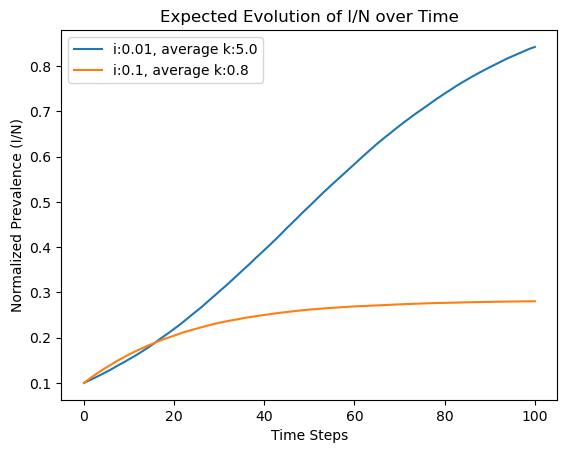

In [11]:
plot_evolution(cases)

In [21]:
titles = [f"i:{case['i']}, average k:{case['average_k']}" for case in cases]
plot_cases_amount(cases, titles)

In [22]:
titles = {
    'case_value': [f"i:{case['i']}, average k:{case['average_k']}" for case in cases],
    'fig_title': "Fraction of Infected Nodes over Time",
    'x': "Time Step",
    'y': "Fraction of Infected Nodes (I/N)"
}
plot_array(cases, titles, base='infected_fractions')

In [23]:
titles = {
    'case_value': [f"i:{case['i']}, average k:{case['average_k']}" for case in cases],
    'fig_title': "Derivative for the expected number of infections",
    'x': "Time Step",
    'y': "Reproduction number (R0)"
}
plot_array(cases, titles, base='R0')

# Epidemics, question 3
## A

In [ ]:
N = 100000

cases = [
    {"name": "i", "N": N, "i": 0.01, "average_k": 5},
    {"name": "ii", "N": N, "i": 0.1, "average_k": 0.8}
]


DECIMAL_ROUND = 2
COFIDENCE_INTERVAL = 1.98

T=100

infected_init=0.1

results_Q1 = run_evolution(cases, 30, T, infected_init)

In [ ]:
def coupled_odes(I, S, b):
    dI_dt = (1 - (1 - b)**I) * S 
    dS_dt = - (1 - (1 - b)**I) * S
    
    return dI_dt, dS_dt

def euler_algo(function, t, b, x0):
    I = np.zeros(len(t))
    S = np.zeros(len(t))
    I[0], S[0] = x0

    for i, (first, second) in enumerate(zip(t, t[1:])):
        dt = second - first
        dI_dt, dS_dt = function(I[i], S[i], b)
        I[i+1] = I[i] + dI_dt * dt
        S[i+1] = S[i] + dS_dt * dt

    return I

plot_data = []

t = np.linspace(0, 10, T+1) 
b_values = [0.1, 0.01]
inital_value = N*b_values[0], N*(1-b_values[0])

for b in b_values:
    numerical = euler_algo(coupled_odes, t, b, inital_value)
    trace = go.Scatter(x=t, y=numerical, mode='markers', name=f'Coupled ODE for b: {b}')
    plot_data.append(trace)

trace_ODE_1 = go.Scatter(x=t, y=results_Q1[0]['infected_counts'], mode='markers', name=f'NR, i: 0.01 and k:5.0')
trace_ODE_2 = go.Scatter(x=t, y=results_Q1[1]['infected_counts'], mode='markers', name=f'NR, i: 0.1 and k:0.8')
plot_data.append(trace_ODE_1)
plot_data.append(trace_ODE_2)

layout = go.Layout(
    title='Numerical Solutions of Coupled ODEs vs network results (NR)',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Amount of people'),
    legend=dict(x=1, y=1)
)


fig = go.Figure(data=plot_data, layout=layout)

fig.show()


# Epidemics, question 4
## A

